# imports and data loads

In [13]:
import os
import re
import pandas as pd
from statistics import mean
from pandas.plotting import table
import matplotlib.pyplot as plt

# Реализация метрики ROUGE на Python
from rouge import Rouge

# from llama_cpp import Llama

# BERTScore использует предварительно обученные контекстные эмбеддинги BERT.
from bert_score import BERTScorer

In [17]:
a0 = pd.read_parquet(r'C:\My_projects\biocad\2etap\data\train-00000-of-00005.parquet')
a2 = pd.read_parquet(r'C:\My_projects\biocad\2etap\data\train-00001-of-00005.parquet')
a3= pd.read_parquet(r'C:\My_projects\biocad\2etap\data\train-00002-of-00005.parquet')
a4 = pd.read_parquet(r'C:\My_projects\biocad\2etap\data\train-00003-of-00005.parquet')
a5 = pd.read_parquet(r'C:\My_projects\biocad\2etap\data\train-00004-of-00005.parquet')
a1 = pd.concat([a0, a2, a3, a4, a5], ignore_index=True)
del a0, a2, a3, a4, a5

## Problems in data
В данных достаточно много проблем:                                                                                                                                                               
>1. ```' , '``` и ```' . '```-очень сило мешало не правильное написание запятой и точки, из-за такой констрикции - **пробел запятая пробел** и **пробел точка пробел** - nltk.sentence плохо опредилял смысловые предложения.

>2. ```Пустые строки``` - это самое ужачное в датасетах, пустые строки приводят к ошибкам, когда ты даже не хочешь их увидеть, чаще всего возникает когда вы захотите пройтись по датасету, но возникнет ошибка **обращение к несуществующему объекту**

>3. ```\n``` - перенос строки, немало важная часть о которой нужно позаботиться, очень сильно мешает при анализе и обработки естественного языка. В данном датасете она используется вооьще не по назначению, во многих строках она стоит в начале всего текста, из-за чего получается полный хаос в данных.


In [5]:
a1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117232 entries, 0 to 119923
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   article   117232 non-null  object
 1   abstract  117232 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [18]:
print('Количество до удаления пустых строк', len(a1))
a1.replace('', pd.NA, inplace=True)
a1.dropna(inplace=True)
print('Количество после удаления пустых строк', len(a1))

Количество до удаления пустых строк 119924
Количество после удаления пустых строк 117232


In [78]:
a1.head()

,article,abstract
0,a recent systematic analysis showed that in 20...,background : the present study was carried out...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...


In [24]:
abstarct_count = a1['abstract'].str.count(' , ').sum()
abstarct_count_n = a1['abstract'].str.count('\n').sum()
abstarct_count_dot = a1['abstract'].str.count(' . ').sum()
article_count = a1['article'].str.count(' , ').sum()
article_count_n = a1['article'].str.count('\n').sum()
article_count_dot = a1['article'].str.count(' . ').sum()
print('Ошибок в написании < , > в колонке <abstract>', abstarct_count, 'Ошибок в написании < . > в колонке <abstract>', abstarct_count_dot, 'Переносов строк в колонке <abstract>', abstarct_count_n)
print('Ошибок в написании < , > в колонке <article>', article_count, 'Ошибок в написании < . > в колонке <article>', article_count_dot, 'Переносов строк в колонке <abstract>', article_count_n)
a1['abstract'] = a1['abstract'].str.replace(' , ', ', ')
a1['abstract'] = a1['abstract'].str.replace(' . ', '. ')
a1['article'] = a1['article'].str.replace(' , ', ', ')
a1['article'] = a1['article'].str.replace(' . ', '. ')
a1['article'] = a1['article'].apply(lambda x: re.sub('\s+', ' ', x).strip())
a1['abstract'] = a1['abstract'].apply(lambda x: re.sub('\s+', ' ', x).strip())

Ошибок в написании < , > в колонке <abstract> 959 Ошибок в написании < . > в колонке <abstract> 1706292
Ошибок в написании < , > в колонке <article> 32470 Ошибок в написании < . > в колонке <article> 28221383


In [25]:
a1

,article,abstract
0,a recent systematic analysis showed that in 20...,background : the present study was carried out...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who a...
2,"tardive dystonia ( td ), a rarer side effect a...",tardive dystonia ( td ) is a serious side effe...
3,"lepidoptera include agricultural pests that, t...",many lepidopteran insects are agricultural pes...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...
...,...,...
119919,eukaryotic cells depend on vesicle - mediated ...,long - distance trafficking of membranous stru...
119920,fiber post systems are routinely used in resto...,aims and objectives : to study the stress conc...
119921,in most of the peer review publications in the...,abstractbackgroundthe objective of this study ...
119922,the reveal registry is a longitudinal registry...,background : patients with pulmonary arterial ...


In [103]:
# bad works, low speed=(
# not for use

# from datasets import load_dataset

# ds = load_dataset("ccdv/pubmed-summarization", "section")

# trash

In [1]:
from llama_cpp import Llama

llm = Llama(model_path=r"C:\My_projects\biocad\ai\gemma-2-9b-it-Q6_K_L.gguf", n_gpu_layers=-1)
output = llm(
        "кто такой Пушкин?",
        max_tokens=1000
)

llama_model_loader: loaded meta data with 33 key-value pairs and 464 tensors from C:\My_projects\biocad\ai\gemma-2-9b-it-Q6_K_L.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma2
llama_model_loader: - kv   1:                               general.name str              = gemma-2-9b-it
llama_model_loader: - kv   2:                      gemma2.context_length u32              = 8192
llama_model_loader: - kv   3:                    gemma2.embedding_length u32              = 3584
llama_model_loader: - kv   4:                         gemma2.block_count u32              = 42
llama_model_loader: - kv   5:                 gemma2.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                gemma2.attention.head_count u32              = 16
llama_model_loader: - kv   7:             gemma2.attent

KeyboardInterrupt: 

## cmake

In [354]:
CMAKE_ARGS="-DLGGML_CUDA=on" 
FORCE_CMAKE=1
%pip install llama-cpp-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip show llama-cpp-python

Name: llama_cpp_python
Version: 0.3.1
Summary: Python bindings for the llama.cpp library
Home-page: https://github.com/abetlen/llama-cpp-python
Author: 
Author-email: Andrei Betlen <abetlen@gmail.com>
License: MIT
Location: c:\anaconda3\lib\site-packages
Requires: diskcache, jinja2, numpy, typing-extensions
Required-by: 


In [2]:
from langchain_community.llms import LlamaCpp

In [20]:
%env CMAKE_ARGS="-DGGML_CUDA=on" 
!pip install llama-cpp-python -U

env: CMAKE_ARGS="-DGGML_CUDA=on"


In [143]:
data = re.sub('\s+', ' ', ds['train']['article'][0]).strip()
# print(data)

sentences = nltk.sent_tokenize(data)

lag = sentences
languages = []
# print(lag)

for i in lag:
    if len(i) > 10:
        i = detect_langs(i)
        for k in range(len(i)):
            languages.append(str(i[k]))

stopWords = set()
unique_data = []
for item in languages:
    # print(item)
    language = item.split(':')[0]
    
    item = item.split(':')
    # print(item)
    item[0] = _languages.get(alpha2=language.split(":")[0]).name
    unique_data.append(':'.join(item))
    sseen_languages = {}
    if item[0] in seen_languages:
        seen_languages[item[0]] += 1
    else:
        seen_languages[item[0]] = 1
    
print(unique_data)

['English:0.9999960033679759', 'English:0.999995851704391', 'English:0.9999971826374958', 'English:0.9999957604179329', 'English:0.9999979945208075', 'English:0.9999962847424222', 'English:0.9999961814742091', 'English:0.9999958439774338', 'English:0.9999967319717167', 'English:0.9999962766429046', 'English:0.9999973070037715', 'English:0.9999961998097207', 'English:0.9999991138775555', 'English:0.9999968809177463', 'English:0.9999976370645941', 'English:0.9999976260762431', 'English:0.9999970443776547', 'English:0.9999963444670116', 'English:0.9999969480299555', 'English:0.999996909087326', 'English:0.9999962124390034', 'English:0.9999987072709641', 'English:0.9999963290521732', 'English:0.9999968206142726', 'English:0.9999989538192657', 'English:0.9999974470313494', 'English:0.9999984625153368', 'English:0.9999989037692666', 'English:0.9999947142422254', 'English:0.9999969514211724', 'English:0.9999959848627882', 'English:0.9999965643608159', 'English:0.9999975734818973', 'English:0.

# language

In [6]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn
from langdetect import detect_langs, detect
from iso639 import languages as _languages



def language(data):
    global reults1
    # data = data[0]
    data = re.sub('\s+', ' ', data).strip()
    # print(data)
    
    sentences = nltk.sent_tokenize(data)
    lag = sentences
    languages = []
    # print(lag)
    
    for i in lag:
        if len(i) > 15:
            try:
                i = detect_langs(i)
            except:
                continue
            for k in range(len(i)):
                languages.append(str(i[k]))
    
    # stopWords = set()
    seen_languages = set()
    # unique_data = []
    
    for item in languages:
        language = item.split(':')[0]
        if language not in seen_languages:
            item = item.split(':')
            item[0] = _languages.get(alpha2=language.split(":")[0]).name
            # print(item[0])
            reults1.append(item[0])
            # unique_data.append(':'.join(item))
            seen_languages.add(language)

In [9]:
from threading import Thread
import time
reults1 = []
th = []
for i in range(0, len(a1)):
    th.append(Thread(target=language, args=([a1[i:i+1]['article'].to_list()[0]])))
h = 0
for t in th:
    t.start()
    h+=100
    print(h)
for t in th:
    t.join()
print(117232)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [106]:
counts = {}
counts_without_trash = {}

for element in reults1:
    if element in counts:
        counts[element] += 1
    else:
        counts[element] = 1

counts_without_trash = counts.copy()

for element, count in counts.items():
    if count < 250:
        if 'other' in counts_without_trash:
            counts_without_trash['other'] += count
            del counts_without_trash[element]
        else:
            counts_without_trash['other'] = count
            del counts_without_trash[element]
    print(f"{element}: {count}") 

Afrikaans: 1251
English: 112189
Catalan: 4484
Czech: 14
Estonian: 462
French: 3401
Finnish: 158
German: 260
Welsh: 1217
Danish: 765
Spanish: 2063
Italian: 6029
Dutch: 1130
Romanian: 3010
Indonesian: 295
Somali: 74
Tagalog: 477
Portuguese: 952
Lithuanian: 267
Swahili (macrolanguage): 47
Croatian: 109
Slovenian: 119
Turkish: 48
Norwegian: 305
Slovak: 52
Latvian: 32
Swedish: 303
Polish: 159
Albanian: 58
Hungarian: 31
Vietnamese: 7


## PubMed-это зарубежный источник информации, люди публикают на международном языке(английском), так же она создана с поддержкой Национальной медицинской библиотекк США. Имходя из этого видно, что очень много литературы написанной на английском языке. Также это международная библиотека, в которою можно выставить статью без каких-либо ограничений на народности и национальность, поэтому мы видим такой разброс языков от Чешского до Немецкого и Французского.

In [124]:
sorted_items = sorted(counts_without_trash.items(), key=lambda item: item[1])
mid = len(sorted_items) // 2
small_items = sorted_items[:mid]
large_items = sorted_items[mid:]

sorted_counts_without_trash = {}
i, j = 0, 0
while i < len(large_items) or j < len(small_items):
    if i < len(large_items):
        key, value = large_items[i]
        sorted_counts_without_trash[key] = value
        i += 1
    if j < len(small_items):
        key, value = small_items[j]
        sorted_counts_without_trash[key] = value
        j += 1

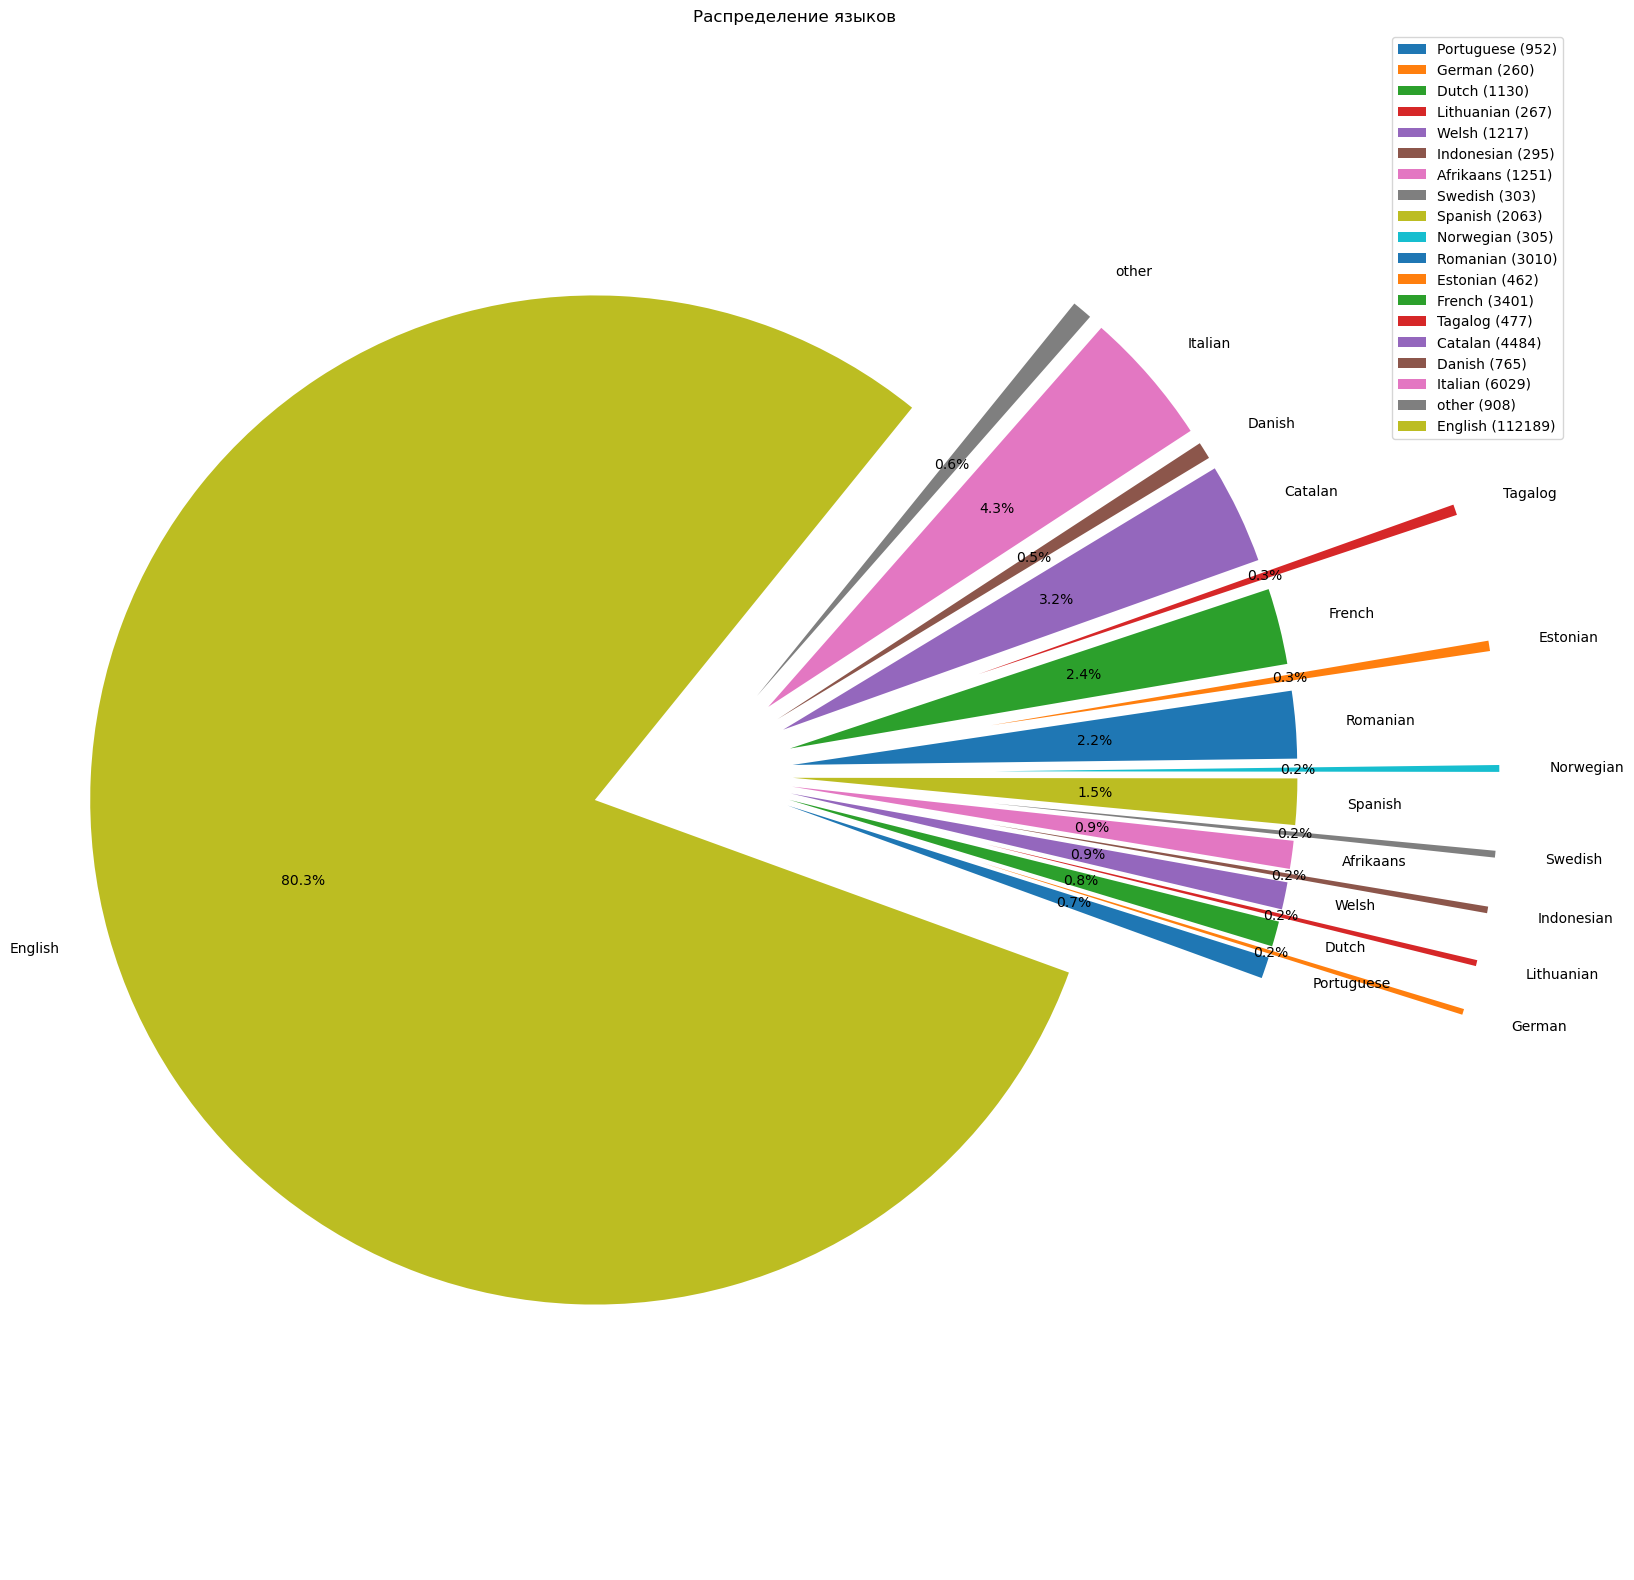

In [126]:
import matplotlib.pyplot as plt
labels = list(sorted_counts_without_trash.keys())
sizes = list(sorted_counts_without_trash.values())

plt.figure(figsize=(20, 20))
explode = [0.2 if count > 600 else 0.6 for count in sizes]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=340, explode=explode)

legend_labels = [f"{label} ({count})" for label, count in zip(labels, sizes)] 
plt.legend(legend_labels, loc="best")

plt.title('Распределение языков')
plt.axis('equal')  

# Отображаем диаграмму
plt.show()

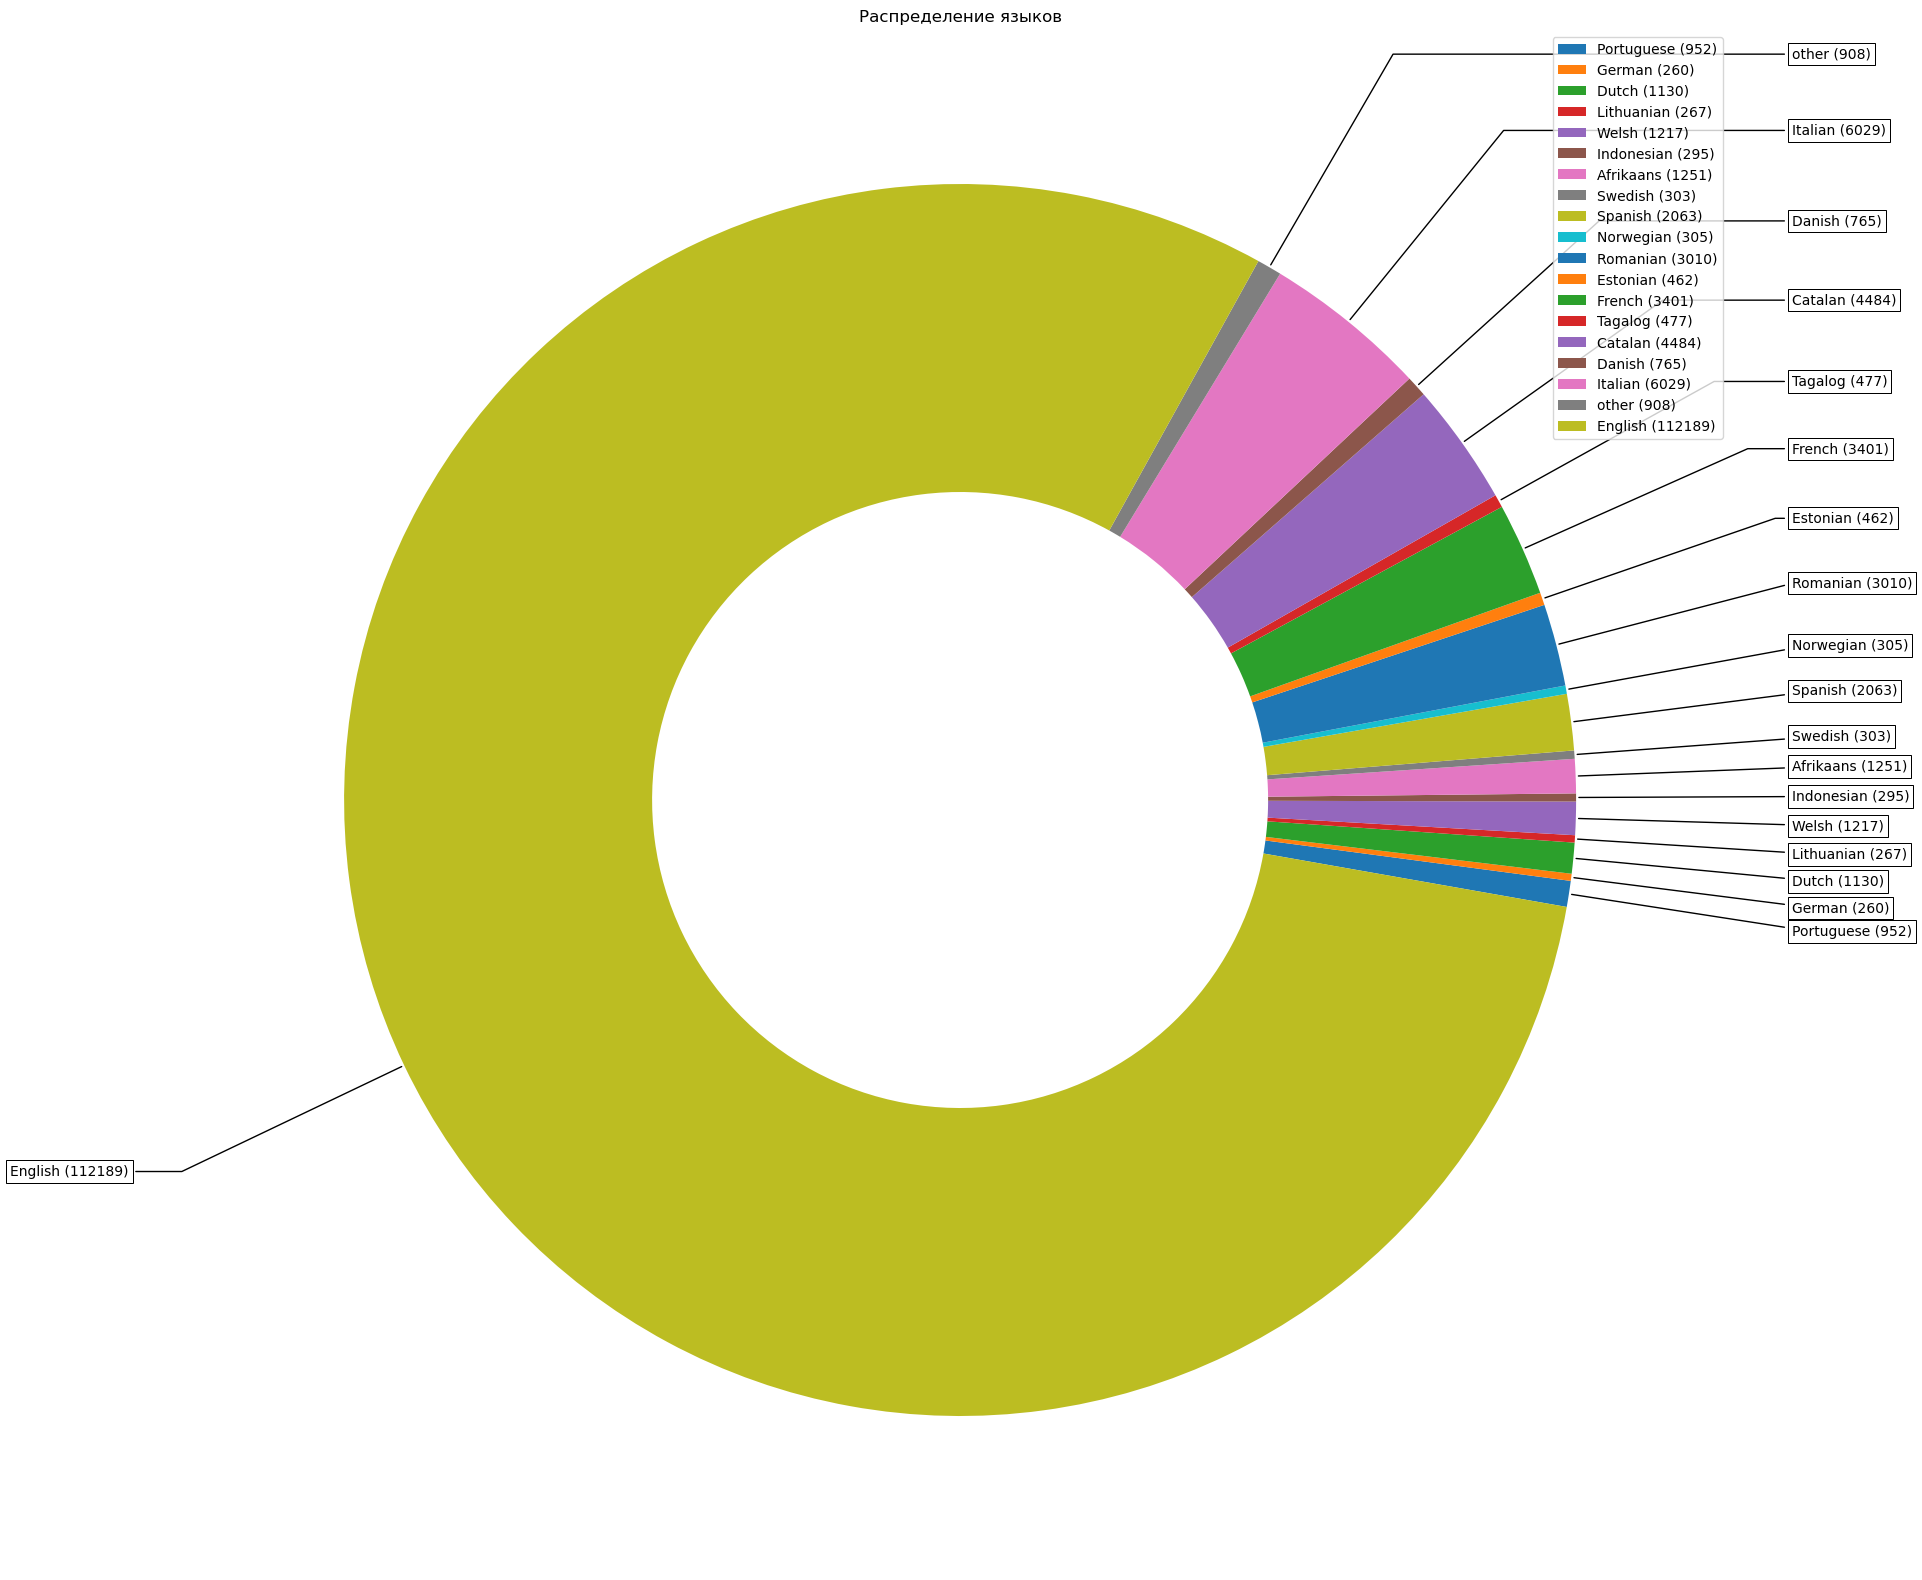

In [122]:
import numpy as np
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

recipe = [f"{label} ({count})" for label, count in zip(labels, sizes)] 

data = sizes

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=350)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.legend(recipe, loc="best")
ax.set_title("Распределение языков")

plt.show()

# classifier

In [127]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#обратная пузырьковая сортировка
def bSort(array):
    length = len(array)
    for i in range(length):
        for j in range(0, length-i-1):
            if array[j][0] < array[j+1][0]:
                array[j], array[j+1] = array[j+1], array[j]
    return array

corpus = (a1['article'].to_list())

# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer()

# Обучение векторайзера
X = vectorizer.fit_transform(corpus)

# Текст для сравнения
theme = [
'Medicine',
'Physics',
'Astrophysics',
'Astrophysics of Galaxies',
'Cosmology and Nongalactic Astrophysics',
'Earth and Planetary Astrophysics',
'High Energy Astrophysical Phenomena',
'Instrumentation and Methods for Astrophysics',
'Solar and Stellar Astrophysics',
'Condensed Matter',
'Disordered Systems and Neural Networks',
'Materials Science',
'Mesoscale and Nanoscale Physics',
'Other Condensed Matter',
'Quantum Gases',
'Soft Condensed Matter',
'Statistical Mechanics',
'Strongly Correlated Electrons',
'Superconductivity',
'General Relativity and Quantum Cosmology',
'High Energy Physics - Experiment',
'High Energy Physics - Lattice',
'High Energy Physics - Phenomenology',
'High Energy Physics - Theory',
'Mathematical Physics',
'Adaptation and Self-Organizing Systems',
'Cellular Automata and Lattice Gases',
'Chaotic Dynamics',
'Exactly Solvable and Integrable Systems',
'Pattern Formation and Solitons',
'Nuclear Experiment',
'Nuclear Theory',
'Accelerator Physics',
'Applied Physics',
'Atmospheric and Oceanic Physics',
'Atomic and Molecular Clusters',
'Atomic Physics',
'Biological Physics',
'Chemical Physics',
'Classical Physics',
'Computational Physics',
'Data Analysis, Statistics and Probability',
'Fluid Dynamics',
'General Physics',
'Geophysics',
'History and Philosophy of Physics',
'Instrumentation and Detectors',
'Medical Physics',
'Optics',
'Physics and Society',
'Physics Education',
'Plasma Physics',
'Popular Physics',
'Space Physics',
'Quantum Physics',
'Algebraic Geometry',
'Algebraic Topology',
'Analysis of PDEs',
'Category Theory',
'Classical Analysis and ODEs',
'Combinatorics',
'Commutative Algebra',
'Complex Variables',
'Differential Geometry',
'Dynamical Systems',
'Functional Analysis',
'General Mathematics',
'General Topology',
'Geometric Topology',
'Group Theory',
'History and Overview',
'Information Theory',
'K-Theory and Homology',
'Logic',
'Mathematical Physics',
'Metric Geometry',
'Number Theory',
'Numerical Analysis',
'Operator Algebras',
'Optimization and Control',
'Probability',
'Quantum Algebra',
'Representation Theory',
'Rings and Algebras',
'Spectral Theory',
'Statistics Theory',
'Symplectic Geometry',
'Computer Science',
'Artificial Intelligence',
'Computation and Language',
'Computational Complexity',
'Computational Engineering, Finance, and Science',
'Computational Geometry',
'Computer Science and Game Theory',
'Computer Vision and Pattern Recognition',
'Computers and Society',
'Cryptography and Security',
'Data Structures and Algorithms',
'Databases',
'Digital Libraries',
'Discrete Mathematics',
'Distributed, Parallel, and Cluster Computing',
'Emerging Technologies',
'Formal Languages and Automata Theory',
'General Literature',
'Graphics',
'Hardware Architecture',
'Human-Computer Interaction',
'Information Retrieval',
'Theory',
'Logic in Computer Science',
'Machine Learning',
'Mathematical Software',
'Multiagent Systems',
'Multimedia',
'Networking and Internet Architecture',
'Neural and Evolutionary Computing',
'Numerical Analysis',
'Operating Systems',
'Other Computer Science',
'Performance',
'Programming Languages',
'Robotics',
'Social and Information Networks',
'Software Engineering',
'Sound',
'Symbolic Computation',
'Systems and Control',
'Quantitative Biology',
'Biomolecules',
'Cell Behavior',
'Genomics',
'Molecular Networks',
'Neurons and Cognition',
'Other Quantitative Biology',
'Populations and Evolution',
'Quantitative Methods',
'Subcellular Processes',
'Tissues and Organ',
'Quantitative Finance',
'Computational Finance',
'Economics',
'General Finance',
'Mathematical Finance',
'Portfolio Management',
'Pricing of Securities',
'Risk Management',
'Statistical Finance',
'Trading and Market Microstructure',
'Statistics',
'Applications',
'Computation',
'Machine Learning',
'Methodology',
'Other Statistics',
'Statistics Theory',
'Electrical Engineering and Systems Science',
'Audio and Speech Processing',
'Image and Video Processing',
'Signal Processing',
'Systems and Control',
'Economics',
'Econometrics',
'General Economics',
'Theoretical Economics',
]

# Преобразование текста в вектор
a = vectorizer.transform(theme)

# Вычисление косинусного сходства
f = cosine_similarity(X, a)

seen_theme = set()
unique_data = []
pre_data = []
for i in range(len(f)):
    k = f[i]
    c = list(zip(k, theme))
    c = bSort(c)[0:10]
    for rex in range(len(c)):
        check = c[rex][1]
        pre_data.append(check)
        if check not in seen_theme:
            unique_data.append(check)
            seen_theme.add(check)

In [163]:
counts = {}
counts_without_trash = {}

for element in pre_data:
    if element in counts:
        counts[element] += 1
    else:
        counts[element] = 1

counts_without_trash = counts.copy()

for element, count in counts.items():
    if count < 2000:
        if 'other' in counts_without_trash:
            counts_without_trash['other'] += count
            del counts_without_trash[element]
        else:
            counts_without_trash['other'] = count
            del counts_without_trash[element]
    print(f"{element}: {count}") 

Systems and Control: 232849
Data Analysis, Statistics and Probability: 100664
Physics Education: 730
Tissues and Organ: 111794
Optimization and Control: 102351
Social and Information Networks: 48390
History and Philosophy of Physics: 112407
Populations and Evolution: 104110
History and Overview: 87989
Data Structures and Algorithms: 74080
Cell Behavior: 8090
Computer Vision and Pattern Recognition: 12215
Image and Video Processing: 12277
Nuclear Experiment: 1531
Distributed, Parallel, and Cluster Computing: 3200
Operating Systems: 1067
Risk Management: 8199
Electrical Engineering and Systems Science: 4212
Adaptation and Self-Organizing Systems: 4735
Disordered Systems and Neural Networks: 3264
Dynamical Systems: 179
Multiagent Systems: 61
Functional Analysis: 3075
Analysis of PDEs: 27142
Neurons and Cognition: 5029
Computation and Language: 2242
Nuclear Theory: 1041
General Literature: 1684
Numerical Analysis: 781
Atomic and Molecular Clusters: 7304
Neural and Evolutionary Computing: 2

## На графике видно очень сильное разделение и разнообразие тем, больше всего тем по системам и контролю, а также по тканям и органам. Pubmed нацелен на биомедицинские исследования, из этого и следует, что в нём находяться очень много публикаций про ткани и органы, а также обработкой больших данных в сфере биомедицины.

In [164]:
sorted_items = sorted(counts_without_trash.items(), key=lambda item: item[1])
mid = len(sorted_items) // 2
small_items = sorted_items[:mid]
large_items = sorted_items[mid:]

sorted_counts_without_trash = {}
i, j = 0, 0
while i < len(large_items) or j < len(small_items):
    if i < len(large_items):
        key, value = large_items[i]
        sorted_counts_without_trash[key] = value
        i += 1
    if j < len(small_items):
        key, value = small_items[j]
        sorted_counts_without_trash[key] = value
        j += 1

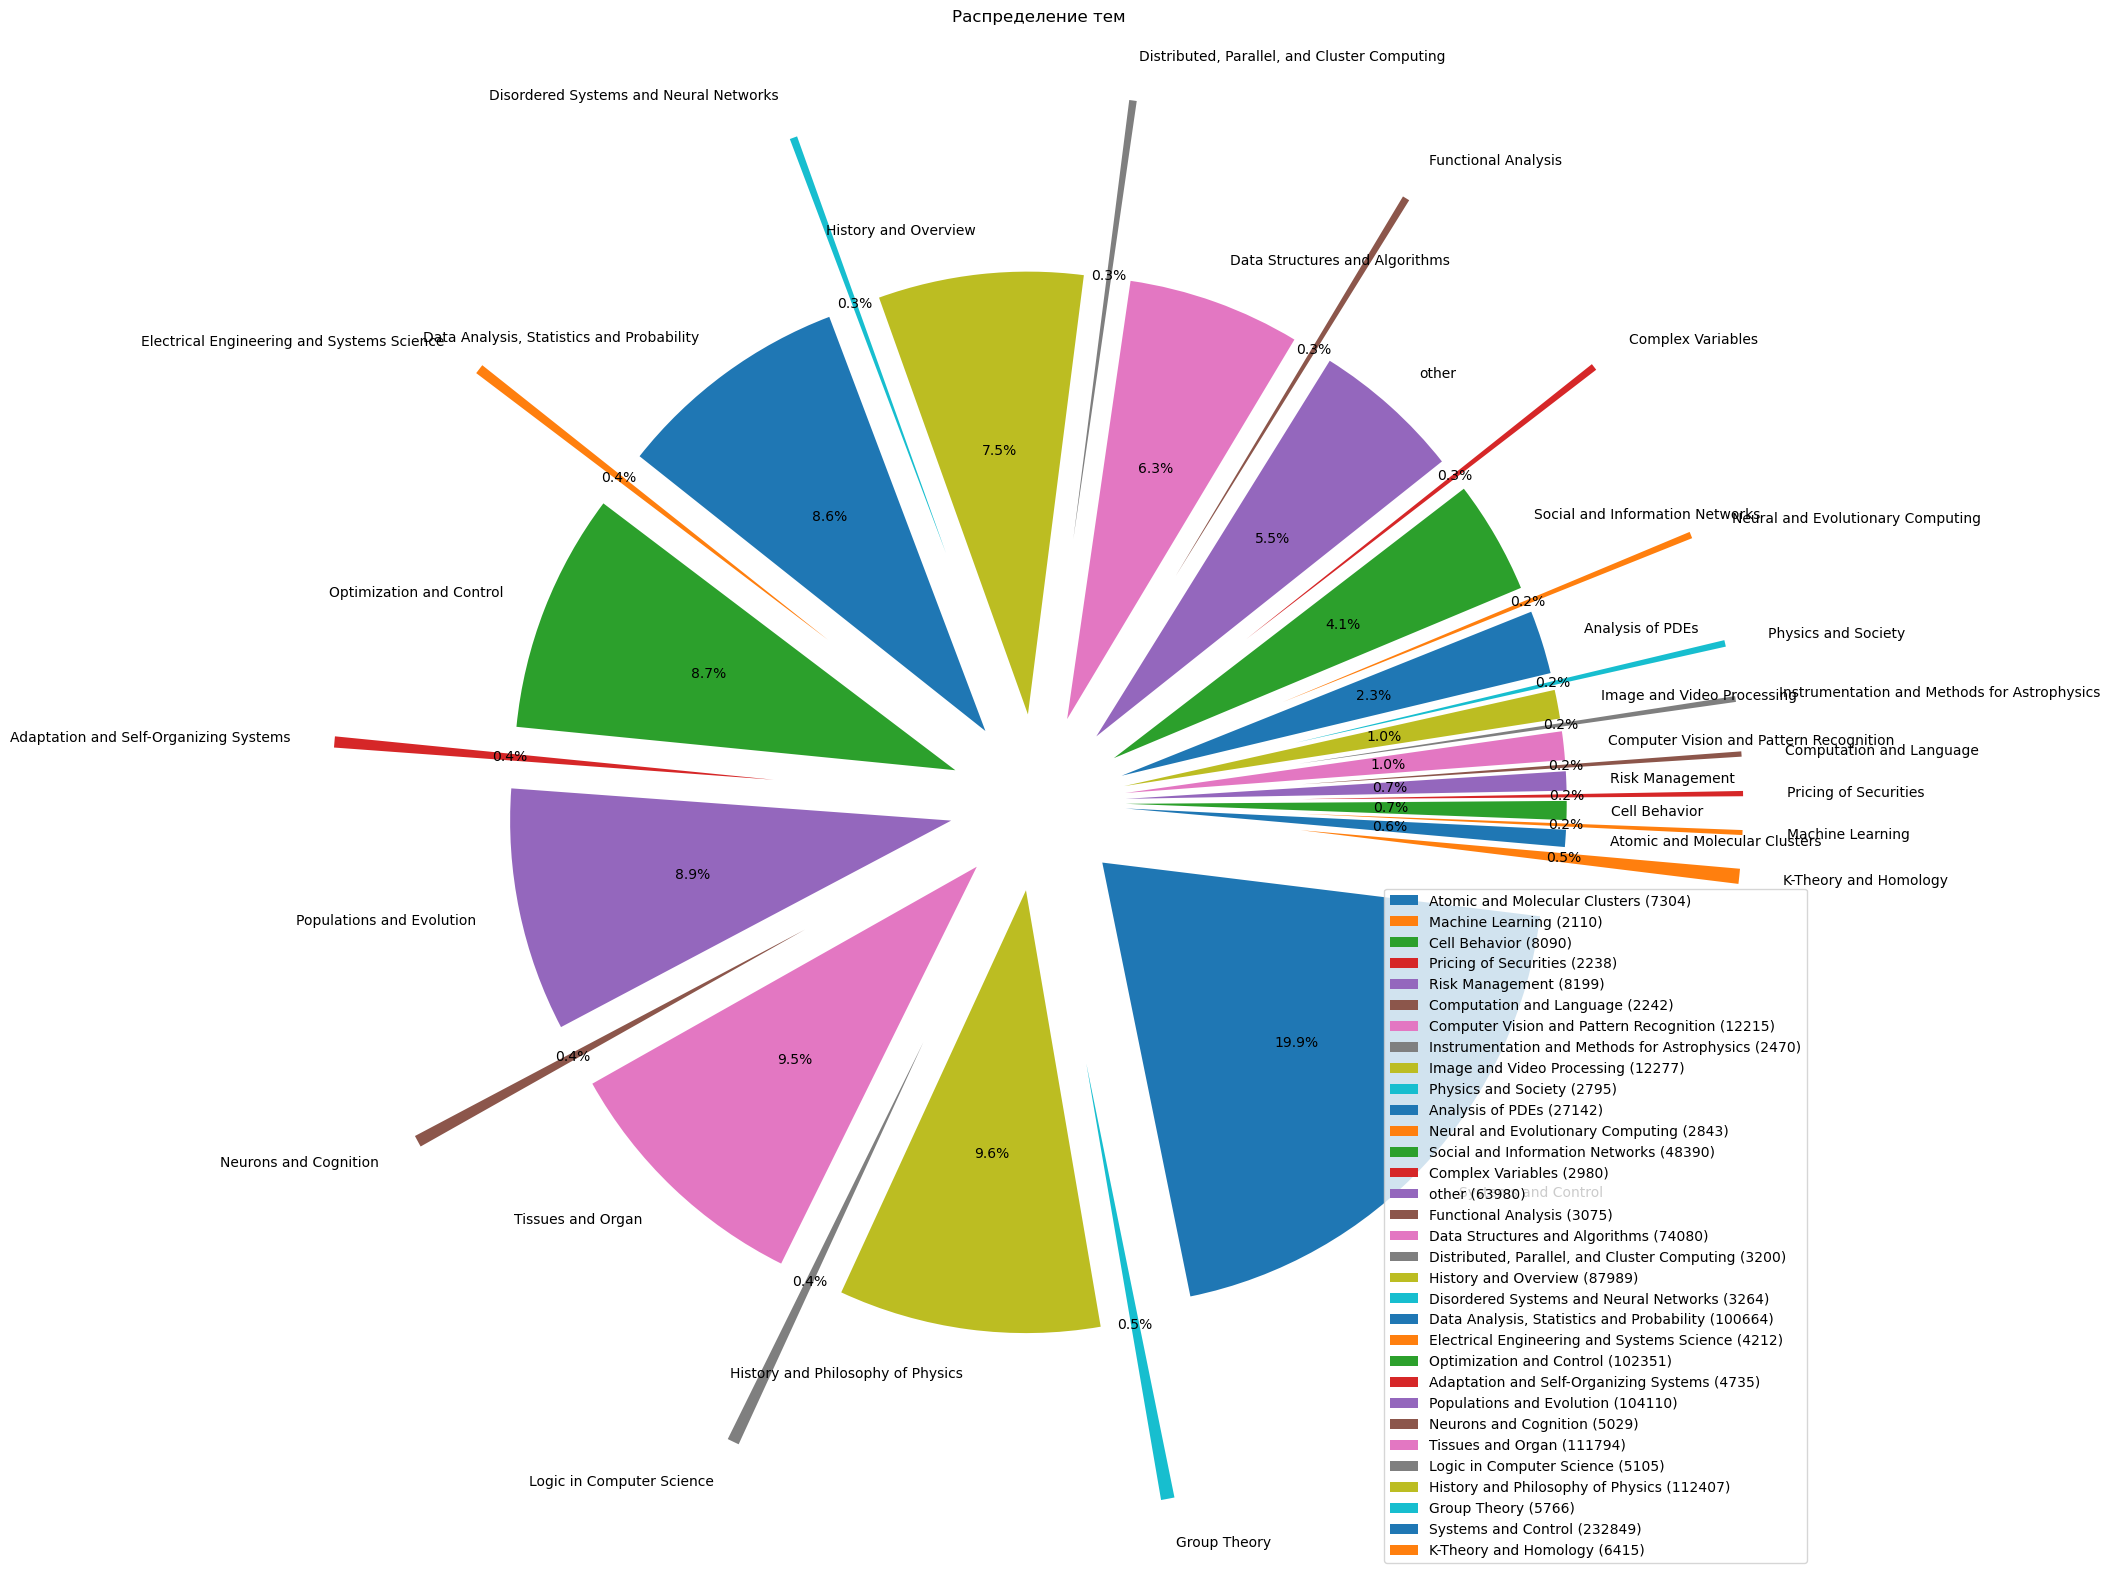

In [165]:
import matplotlib.pyplot as plt
labels = list(sorted_counts_without_trash.keys())
sizes = list(sorted_counts_without_trash.values())

plt.figure(figsize=(20, 20))
explode = [0.2 if count > 6500 else 0.6 for count in sizes]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=-5, explode=explode)

legend_labels = [f"{label} ({count})" for label, count in zip(labels, sizes)] 
plt.legend(legend_labels, loc="best")

plt.title('Распределение тем')
plt.axis('equal')  

# Отображаем диаграмму
plt.show()

# models

In [45]:
from langchain_core.prompts import PromptTemplate
from langchain_community.llms import LlamaCpp
from langchain_core.documents import Document
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.summarize import load_summarize_chain
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
import dataframe_image as dfi

callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

n_gpu_layers = -1
n_batch = 2048

# Define LLM
llm_g = LlamaCpp(
    model_path=r"C:\My_projects\biocad\ai\gemma-2-9b-it-Q6_K_L.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=15000,
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
)
llm_l = LlamaCpp(
    model_path=r"C:\My_projects\biocad\ai\Llama-3.2-3B-Instruct-Q6_K_L.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=15000,
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
)

llama_model_loader: loaded meta data with 33 key-value pairs and 464 tensors from C:\My_projects\biocad\ai\gemma-2-9b-it-Q6_K_L.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma2
llama_model_loader: - kv   1:                               general.name str              = gemma-2-9b-it
llama_model_loader: - kv   2:                      gemma2.context_length u32              = 8192
llama_model_loader: - kv   3:                    gemma2.embedding_length u32              = 3584
llama_model_loader: - kv   4:                         gemma2.block_count u32              = 42
llama_model_loader: - kv   5:                 gemma2.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                gemma2.attention.head_count u32              = 16
llama_model_loader: - kv   7:             gemma2.attent

In [ ]:
docs = [
    Document(page_content=str(a1[0:1]['article'].to_list()[0])),
    Document(page_content=str(a1[1:2]['article'].to_list()[0])),
    Document(page_content=str(a1[2:3]['article'].to_list()[0])),
    Document(page_content=str(a1[3:4]['article'].to_list()[0])),
]

prompt_template = """Write a concise summary of the following:
"{context}"
CONCISE SUMMARY:"""

prompt = PromptTemplate.from_template(prompt_template)

chain = create_stuff_documents_chain(llm, prompt)
summary = chain.invoke({"context": docs})

In [ ]:
a1

In [51]:

from threading import Thread
docs = [
    [Document(page_content="""Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with LangSmith.""")],
    [Document(page_content="""a recent systematic analysis showed that in 2011, 314 ( 296 - 331 ) million children younger than 5 years were mildly, moderately or severely stunted and 258 ( 240 - 274 ) million were mildly, moderately or severely underweight in the developing countries. in iran a study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2%, 8.6% and 1.5%, for underweight, overweight and obesity, respectively . """)],
    # Document(page_content=str(a1[0:1]['article'].to_list()[0])),
    # Document(page_content=str(a1[1:2]['article'].to_list()[0])),
    # Document(page_content=str(a1[2:3]['article'].to_list()[0])),
    # Document(page_content=str(a1[3:4]['article'].to_list()[0])),
]

docs_ref = [
    """Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with LangSmith.""",
    """a recent systematic analysis showed that in 2011, 314 ( 296 - 331 ) million children younger than 5 years were mildly, moderately or severely stunted and 258 ( 240 - 274 ) million were mildly, moderately or severely underweight in the developing countries. in iran a study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2%, 8.6% and 1.5%, for underweight, overweight and obesity, respectively . """
]
summarys_g = []
summarys_l = []
th = []

# for i in range(0, 10):
#     docs.append([Document(page_content=str(a1[0:1]['article'].to_list()[0]))])
#     docs_ref.append(str(a1[0:1]['article'].to_list()[0]))
    
for i in range(len(docs)):
    chain_g = load_summarize_chain(llm_g, chain_type="stuff")
    summary_g = chain.invoke(docs[i])
    summary_g = re.sub('\s+', ' ', summary_g['output_text'])
    chain_l = load_summarize_chain(llm_l, chain_type="stuff")
    summary_l = chain.invoke(docs[i])
    summary_l = re.sub('\s+', ' ', summary_l['output_text'])
    summarys_g.append(summary_g)
    summarys_l.append(summary_l)
summarys = {
    'gemma' : summarys_g,
    'llama' : summarys_l
}
del summary_g, summary_l

Llama.generate: 11 prefix-match hit, remaining 67 prompt tokens to eval




LangSmith is a tool for inspecting and debugging complex LangChain applications that involve multiple LLM calls and steps. 




llama_perf_context_print:        load time =    3873,65 ms
llama_perf_context_print: prompt eval time =       0,00 ms /    67 tokens (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0,00 ms /    25 runs   (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    8001,33 ms /    92 tokens


Llama.generate: 77 prefix-match hit, remaining 1 prompt tokens to eval


For complex LangChain applications with multiple LLM calls, **LangSmith provides a powerful tool for debugging and understanding the execution flow.** 


llama_perf_context_print:        load time =    3873,65 ms
llama_perf_context_print: prompt eval time =       0,00 ms /     1 tokens (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0,00 ms /    30 runs   (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    5951,42 ms /    31 tokens
Llama.generate: 11 prefix-match hit, remaining 128 prompt tokens to eval





Globally, hundreds of millions of children under 5 years old in developing countries suffer from stunting and underweight. In Iran, a study found lower rates of these issues among high school girls in Sistan and Baluchestan, with obesity being the least prevalent. 


llama_perf_context_print:        load time =    3873,65 ms
llama_perf_context_print: prompt eval time =       0,00 ms /   128 tokens (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0,00 ms /    57 runs   (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   16752,80 ms /   185 tokens
Llama.generate: 138 prefix-match hit, remaining 1 prompt tokens to eval




Globally, millions of children under five are stunted or underweight. In Iran, high school girls show lower rates of malnutrition but higher rates of overweight and obesity compared to global averages.  


llama_perf_context_print:        load time =    3873,65 ms
llama_perf_context_print: prompt eval time =       0,00 ms /     1 tokens (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0,00 ms /    41 runs   (    0,00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    8022,15 ms /    42 tokens


In [2]:
docs_ref = [
    """Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with LangSmith.""",
    """a recent systematic analysis showed that in 2011, 314 ( 296 - 331 ) million children younger than 5 years were mildly, moderately or severely stunted and 258 ( 240 - 274 ) million were mildly, moderately or severely underweight in the developing countries. in iran a study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2%, 8.6% and 1.5%, for underweight, overweight and obesity, respectively . """
]
summarys= {'gemma': [' LangSmith is a tool for inspecting and debugging complex LangChain applications that involve multiple LLM calls and steps. ',
  ' Globally, hundreds of millions of children under 5 years old in developing countries suffer from stunting and underweight. In Iran, a study found lower rates of these issues among high school girls in Sistan and Baluchestan, with obesity being the least prevalent. '],
 'llama': [' For complex LangChain applications with multiple LLM calls, **LangSmith provides a powerful tool for debugging and understanding the execution flow.** ',
  ' Globally, millions of children under five are stunted or underweight. In Iran, high school girls show lower rates of malnutrition but higher rates of overweight and obesity compared to global averages. ']}

In [54]:
summarys['gemma'][0]

' LangSmith is a tool for inspecting and debugging complex LangChain applications that involve multiple LLM calls and steps. '

In [ ]:
docs_ref 

In [24]:
def get_rouge_scores(text1, text2):
    rouge = Rouge()
    return rouge.get_scores(text1, text2)


rouge_scores_out = []
evals_1_rouge = []
evals_2_rouge = []
# рассчет ROUGE для обоих резюме, используя референсное
for i, k in enumerate(docs_ref):
    eval_1_rouge = get_rouge_scores(summarys['gemma'][i], k)
    eval_2_rouge = get_rouge_scores(summarys['llama'][i], k)
    evals_1_rouge.append(eval_1_rouge)
    evals_2_rouge.append(eval_2_rouge)
evals = {}
evals['gemma'] = evals_1_rouge
evals['llama'] = evals_2_rouge
av_1 = []
av_2 = []
min1 = []
min2 = []
max1 = []
max2 = []
for metric in ["rouge-1", "rouge-2", "rouge-l"]:
    for i in range(len(docs_ref)):
        for label in ["F-Score"]:
                eval_1_score = evals["gemma"][i][0][metric][label[0].lower()]
                eval_2_score = evals["llama"][i][0][metric][label[0].lower()]
                av_1.append(eval_1_score)
                av_2.append(eval_2_score)
                min1.append(eval_1_score)
                max1.append(eval_1_score)
                min2.append(eval_2_score)
                max2.append(eval_1_score)
                
    av_1 = mean(i for i in av_1)
    av_2 = mean(i for i in av_2)
    min1 = min(i for i in min1)
    min2 = min(i for i in min2)
    max1 = max(i for i in max1)
    max2 = max(i for i in max2)
    
    row = {
        "Metric": f"{metric} ({label}) avg",
        "gemma": av_1,
        "llama": av_2,
    }
    row1 = {
        "Metric": f"{metric} ({label}) min",
        "gemma": min1,
        "llama": min2,
    }
    row2 = {
        "Metric": f"{metric} ({label}) max",
        "gemma": max1,
        "llama": max2,
    }
    rouge_scores_out.append(row)
    rouge_scores_out.append(row1)
    rouge_scores_out.append(row2)
    av_1 = []
    av_2 = []
    min1 = []
    min2 = []
    max1 = []
    max2 = []
print(rouge_scores_out)


def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen" if v else "background-color: white" for v in is_max]


rouge_scores_out = (
    pd.DataFrame(rouge_scores_out)
    .set_index("Metric")
    .style.apply(highlight_max, axis=1)
)

rouge_scores_out

# fig, ax = plt.subplots(figsize=(5, 2))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=rouge_scores_out.values, colLabels=rouge_scores_out.columns, loc='center')
# # Save the table as an image file
# plt.savefig('Rouge.png')
# rouge_scores_out.to_image('rouge.png')
dfi.export(rouge_scores_out, 'Rouge.png')

[{'Metric': 'rouge-1 (F-Score) avg', 'gemma': 0.3222446191834508, 'llama': 0.23559928001451963}, {'Metric': 'rouge-1 (F-Score) min', 'gemma': 0.29032257652445376, 'llama': 0.21538461101065096}, {'Metric': 'rouge-1 (F-Score) max', 'gemma': 0.35416666184244794, 'llama': 0.35416666184244794}, {'Metric': 'rouge-2 (F-Score) avg', 'gemma': 0.06883116456063454, 'llama': 0.04450112965656072}, {'Metric': 'rouge-2 (F-Score) min', 'gemma': 0.028571424751020924, 'llama': 0.02777777376543268}, {'Metric': 'rouge-2 (F-Score) max', 'gemma': 0.10909090437024814, 'llama': 0.10909090437024814}, {'Metric': 'rouge-l (F-Score) avg', 'gemma': 0.2691532213339885, 'llama': 0.22021466462990424}, {'Metric': 'rouge-l (F-Score) min', 'gemma': 0.2258064474921957, 'llama': 0.18461538024142018}, {'Metric': 'rouge-l (F-Score) max', 'gemma': 0.3124999951757813, 'llama': 0.3124999951757813}]


In [8]:
# Создать экземпляр объекта BERTScorer для английского языка
scorer = BERTScorer(lang="en")
# from math import mean

# Рассчет BERTScore для резюме 1
# P1, R1, F1_1 представляют Precision, Recall, и F1 меру.

# Рассчет BERTScore для резюме 2
# P1, R1, F1_1 представляют Precision, Recall, и F1 меру.
evals_1_bert = []
evals_2_bert = []
bert_scores = []
for i, k in enumerate(docs_ref):
    P1, R1, F1_1 = scorer.score([summarys['gemma'][i]], [k])
    P2, R2, F2_2 = scorer.score([summarys['llama'][i]], [k])
    evals_1_bert.append(F1_1.tolist()[0])
    evals_2_bert.append(F2_2.tolist()[0])
    
av_1 = mean(i for i in evals_1_bert)
av_2 = mean(i for i in evals_2_bert)
min1 = min(i for i in evals_1_bert)
min2 = min(i for i in evals_2_bert)
max1 = max(i for i in evals_1_bert)
max2 = max(i for i in evals_2_bert)

row = {
        "Metric": f"bert_score F1 avg",
        "gemma": av_1,
        "llama": av_2,
    }

row1 = {
        "Metric": f"bert_score F1 min",
        "gemma": min1,
        "llama": min2,
    }

row2 = {
        "Metric": f"bert_score F1 max",
        "gemma": max1,
        "llama": max2,
    }
bert_scores.append(row)
bert_scores.append(row1)
bert_scores.append(row2)

def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen" if v else "background-color: white" for v in is_max]


bert_scores = (
    pd.DataFrame(bert_scores)
    .set_index("Metric")
    .style.apply(highlight_max, axis=1)
)

bert_scores



dfi.export(bert_scores, 'Bert.png')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,gemma,llama
Metric,,
bert_score F1 avg,0.882905,0.877611
bert_score F1 min,0.873585,0.857121
bert_score F1 max,0.892226,0.898102


In [ ]:
evals_1_rouge